# Double integrator

For this example we demonstrate learning control for a double integrator system. In this case we learn the control from directly interacting with the system in a typical RL scenario. 

In [2]:
# !pip install setuptools==61.0.0 pyts mlflow plum-dispatch==1.7.2 torchdiffeq
# !pip install git+https://github.com/pnnl/neuromancer.git@master --ignore-requires-python --no-deps
# Uncomment pip installs for Colab notebook    
import torch
from neuromancer.system import Node, System
from neuromancer import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.plot import pltCL, pltPhase

# Node and System classes

The Node class is a simple wrapper for any callable pytorch function or nn.Module which provides names for the inputs and outputs to be used in composition of a potentially cyclic computational graph.  

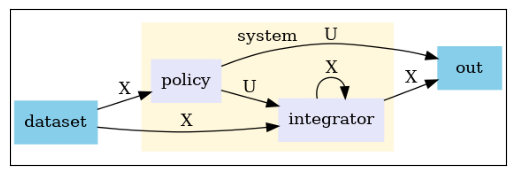

In [3]:
# Double integrator parameters
nx = 2
nu = 1
A = torch.tensor([[1.2, 1.0],
                  [0.0, 1.0]])
B = torch.tensor([[1.0],
                  [0.5]])

# closed loop system definition
mlp = blocks.MLP(nx, nu, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[20, 20, 20, 20])
policy = Node(mlp, ['X'], ['U'], name='policy')

xnext = lambda x, u: x @ A.T + u @ B.T
double_integrator = Node(xnext, ['X', 'U'], ['X'], name='integrator')
cl_system = System([policy, double_integrator])
cl_system.show()

# Training dataset generation

For a training dataset we randomly sample points away from the origin of the 2D space the systemn operates in. 

In [4]:
# Training dataset generation
train_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='train')  # Split conditions into train and dev
dev_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='dev')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=3333,
                                           collate_fn=train_data.collate_fn, shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=3333,
                                         collate_fn=dev_data.collate_fn, shuffle=False)

# Optimization problem

We want to learn a controller that stabilizes the double integrator system. In other words we would like a control policy that pushes the system to stay at the origin. 

In [6]:
# Define optimization problem
u = variable('U')
x = variable('X')
action_loss = 0.001 * (u == 0.)^2  # control penalty
regulation_loss = 5. * (x == 0.)^2  # target position
loss = PenaltyLoss([action_loss, regulation_loss], [])
problem = Problem([cl_system], loss)
optimizer = torch.optim.AdamW(policy.parameters(), lr=0.001)

# Optimize problem with a system rollout of 2 time steps


In [7]:
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer,
    epochs=500,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric='dev_loss',
    warmup=400,
)

# Train model with prediction horizon of 2
cl_system.nsteps = 2
best_model = trainer.train()

/home/tuor369/anaconda3/envs/condarelease/lib/python3.10/site-packages/neuromancer/constraint.py:153: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([3333, 2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)
/home/tuor369/anaconda3/envs/condarelease/lib/python3.10/site-packages/neuromancer/constraint.py:153: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([3333, 3, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)


epoch: 0  train_loss: 105.77971649169922
epoch: 1  train_loss: 105.5111083984375
epoch: 2  train_loss: 105.25995635986328
epoch: 3  train_loss: 105.02628326416016
epoch: 4  train_loss: 104.8080062866211
epoch: 5  train_loss: 104.60324096679688
epoch: 6  train_loss: 104.4092788696289
epoch: 7  train_loss: 104.22418975830078
epoch: 8  train_loss: 104.04571533203125
epoch: 9  train_loss: 103.87319946289062
epoch: 10  train_loss: 103.7044677734375
epoch: 11  train_loss: 103.53734588623047
epoch: 12  train_loss: 103.36968231201172
epoch: 13  train_loss: 103.19938659667969
epoch: 14  train_loss: 103.02477264404297
epoch: 15  train_loss: 102.84465026855469
epoch: 16  train_loss: 102.65878295898438
epoch: 17  train_loss: 102.46688842773438
epoch: 18  train_loss: 102.26750183105469
epoch: 19  train_loss: 102.05976867675781
epoch: 20  train_loss: 101.8419189453125
epoch: 21  train_loss: 101.61164855957031
epoch: 22  train_loss: 101.36711883544922
epoch: 23  train_loss: 101.10714721679688
epoch: 

epoch: 200  train_loss: 20.763507843017578
epoch: 201  train_loss: 20.76253318786621
epoch: 202  train_loss: 20.761587142944336
epoch: 203  train_loss: 20.760671615600586
epoch: 204  train_loss: 20.75977897644043
epoch: 205  train_loss: 20.758913040161133
epoch: 206  train_loss: 20.75807762145996
epoch: 207  train_loss: 20.757266998291016
epoch: 208  train_loss: 20.7564754486084
epoch: 209  train_loss: 20.755706787109375
epoch: 210  train_loss: 20.754959106445312
epoch: 211  train_loss: 20.75423240661621
epoch: 212  train_loss: 20.75351905822754
epoch: 213  train_loss: 20.75282859802246
epoch: 214  train_loss: 20.75215721130371
epoch: 215  train_loss: 20.751502990722656
epoch: 216  train_loss: 20.750865936279297
epoch: 217  train_loss: 20.7502498626709
epoch: 218  train_loss: 20.74964714050293
epoch: 219  train_loss: 20.749059677124023
epoch: 220  train_loss: 20.748493194580078
epoch: 221  train_loss: 20.747934341430664
epoch: 222  train_loss: 20.747390747070312
epoch: 223  train_loss:

epoch: 393  train_loss: 20.714147567749023
epoch: 394  train_loss: 20.714109420776367
epoch: 395  train_loss: 20.71407127380371
epoch: 396  train_loss: 20.714031219482422
epoch: 397  train_loss: 20.713991165161133
epoch: 398  train_loss: 20.713953018188477
epoch: 399  train_loss: 20.713911056518555
epoch: 400  train_loss: 20.7138729095459
epoch: 401  train_loss: 20.713834762573242
epoch: 402  train_loss: 20.713794708251953
epoch: 403  train_loss: 20.71375846862793
epoch: 404  train_loss: 20.713720321655273
epoch: 405  train_loss: 20.713682174682617
epoch: 406  train_loss: 20.71364974975586
epoch: 407  train_loss: 20.713611602783203
epoch: 408  train_loss: 20.713573455810547
epoch: 409  train_loss: 20.713537216186523
epoch: 410  train_loss: 20.7135009765625
epoch: 411  train_loss: 20.713464736938477
epoch: 412  train_loss: 20.713430404663086
epoch: 413  train_loss: 20.713396072387695
epoch: 414  train_loss: 20.713361740112305
epoch: 415  train_loss: 20.71332550048828
epoch: 416  train_l

# Evaluate best model on a system rollout of 50 time steps


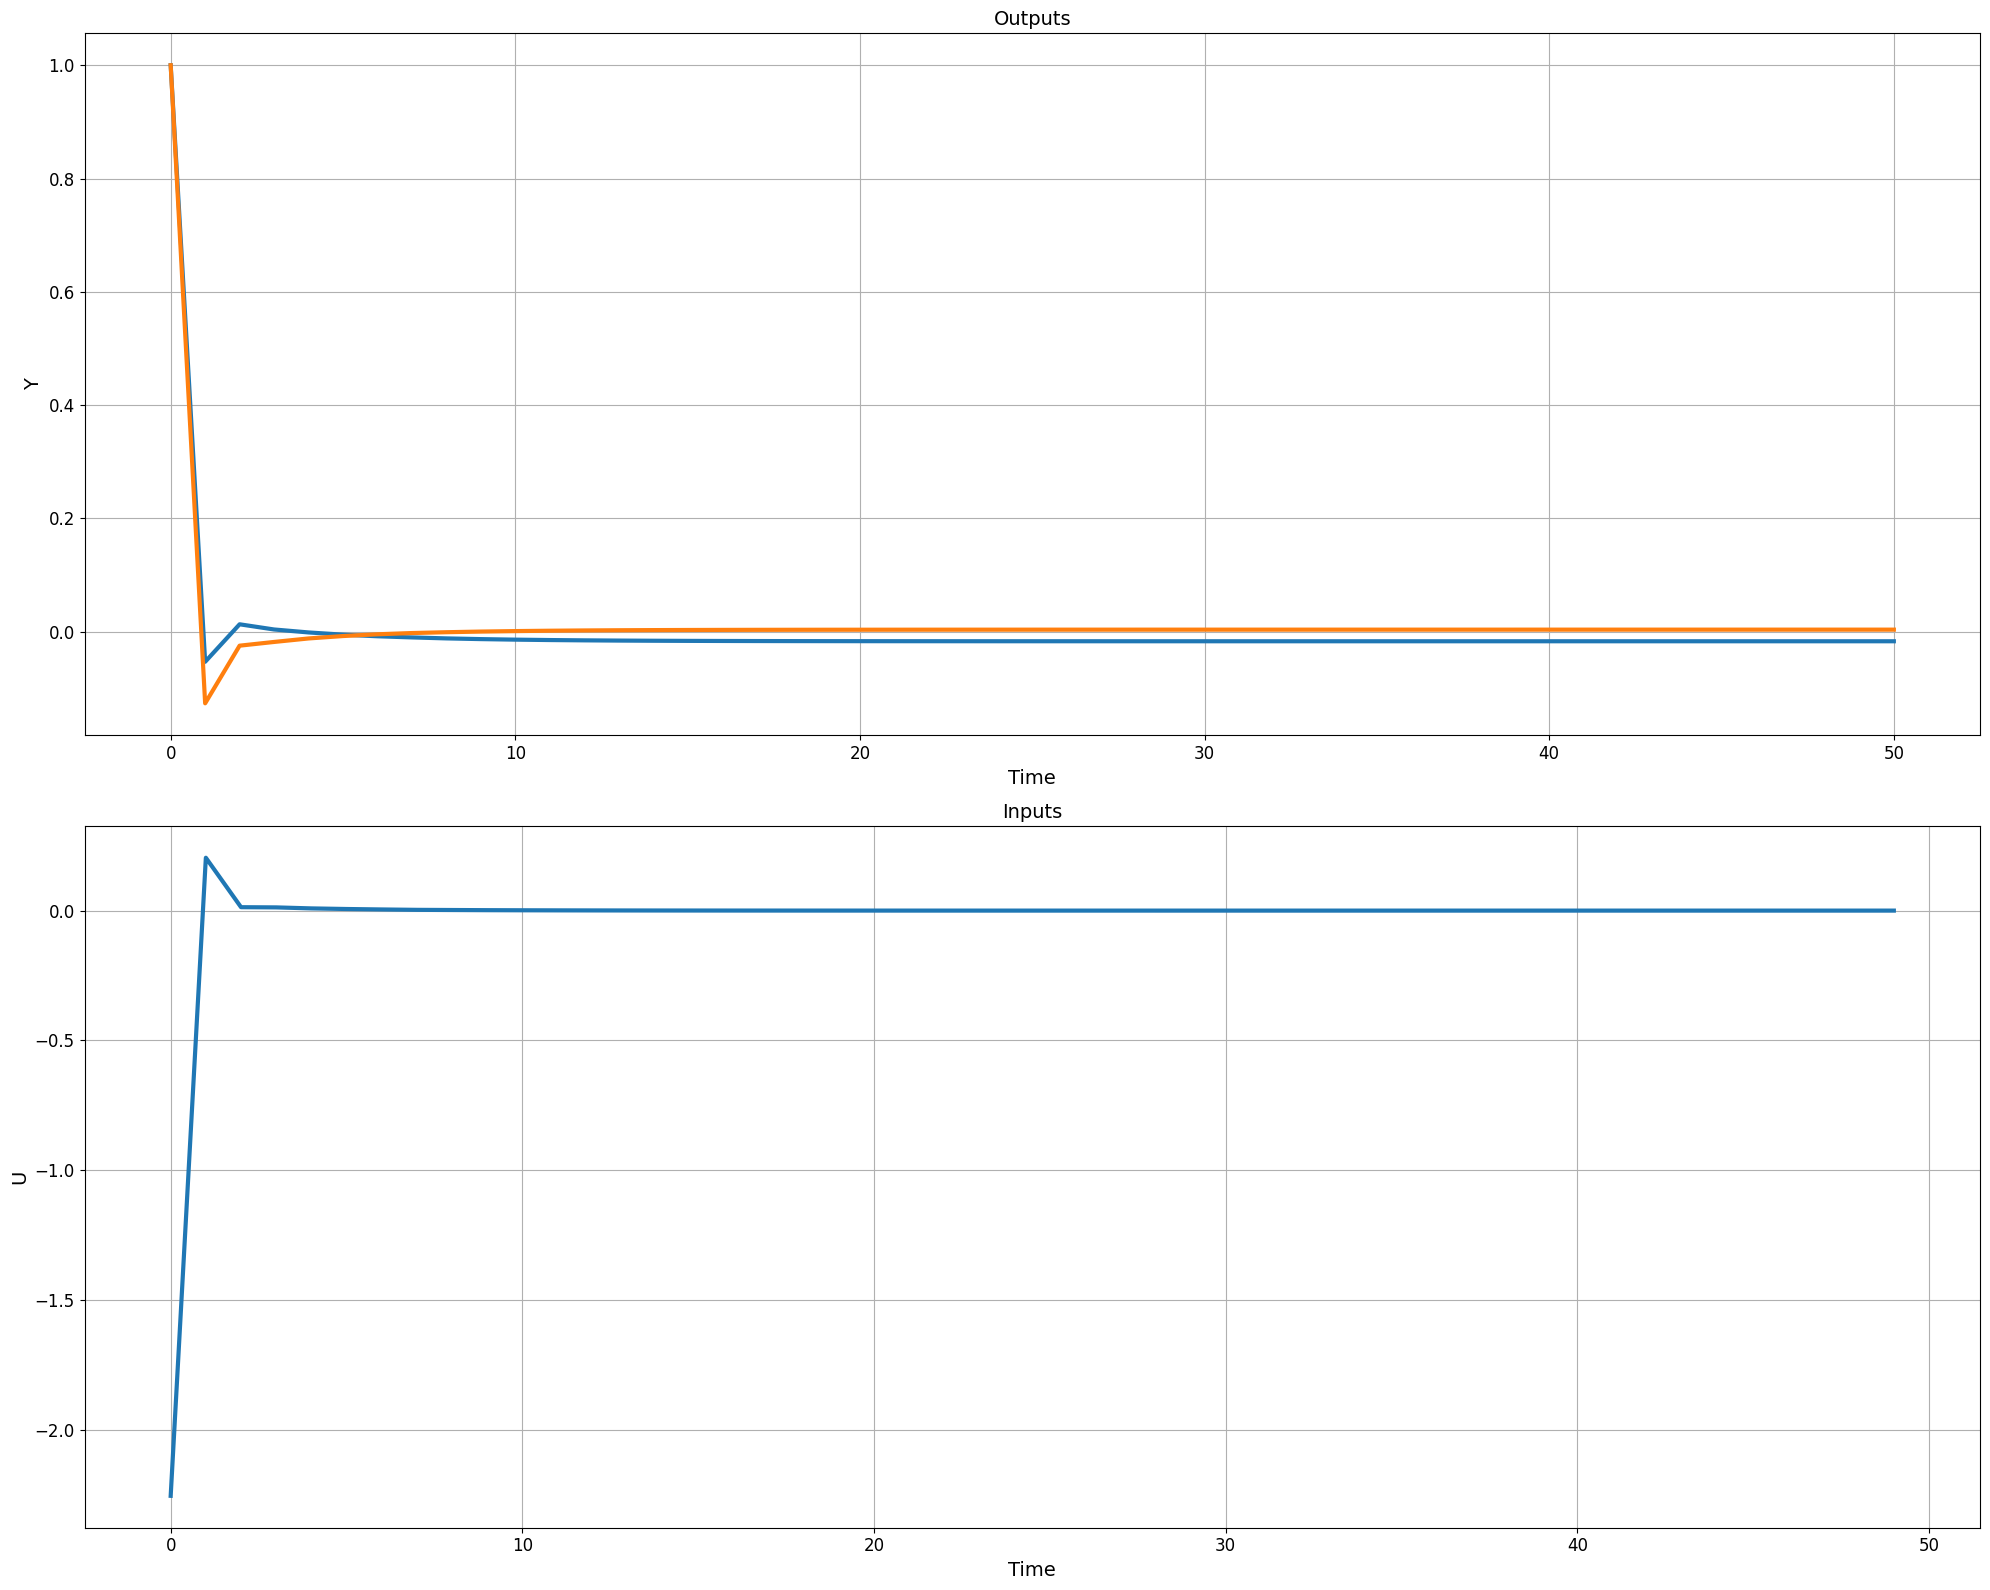

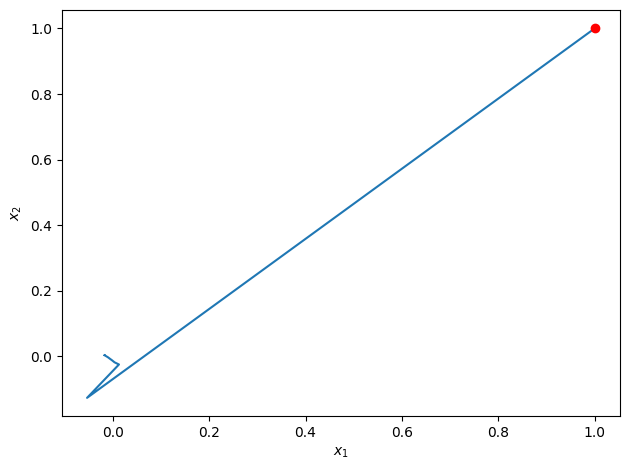

<Figure size 640x480 with 0 Axes>

In [8]:
# Test best model with prediction horizon of 50
problem.load_state_dict(best_model)
data = {'X': torch.ones(1, 1, nx, dtype=torch.float32)}
cl_system.nsteps = 50
trajectories = cl_system(data)
pltCL(Y=trajectories['X'].detach().reshape(51, 2), U=trajectories['U'].detach().reshape(50, 1), figname='cl.png')
pltPhase(X=trajectories['X'].detach().reshape(51, 2), figname='phase.png')